# NH 주식보유기간 예측

<img src='logo.png'><br>

# Columns info
<pre>
고객 및 주거래계좌 정보(CUS_INFO.CSV)
- CUS_AGE_STN_CD     연령구간
- IVS_ICN_CD         투자성향
- CUS_AET_STN_CD     고객자산구간
- MRZ_PDT_TP_SGM_CD  주거래상품군
- LSG_SGM_CD         Life Stage
- TCO_CUS_GRD_CD     고객등급
- TOT_IVS_TE_SGM_CD  총 투자기간
- MRZ_BTP_DIT_CD     주 거래 업종구분

국내주식 잔고이력(STK_BNC_HIST.CSV)
- ACT_ID             계좌번호
- BSE_DT             기준일자
- IEM_CD             종목코드
- BNC_QTY            잔고수량
- TOT_AET_AMT        잔고금액
- STK_PAR_PR         액면가

종목정보(IEM_INFO.CSV)
IEM_CD               종목코드
BTP_CFC_CD           종목업종 
MKT_PR_TAL_SCL_TP_CD 시가총액규모유형
STK_DIT_CD           시장구분
IEM_KRL_NM           종목한글명
</pre>

# 모듈 설치 및 import

In [1]:
# #필요시 설치
# !pip install finance-datareader
# !pip install catboost
# !pip install pykrx

In [2]:
import pandas as pd
pd.set_option("display.max_row", 100)
pd.set_option("display.max_column", 100)
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

import FinanceDataReader as fdr

# decomposition.PCA
from sklearn.decomposition import PCA
# preprocessing.scaling
from sklearn.preprocessing import LabelEncoder, RobustScaler

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error as mse
from catboost import CatBoostRegressor

# Data Load

In [3]:
cus = pd.read_csv("open/cus_info.csv")
iem = pd.read_csv("open/iem_info_20210902.csv")
hist = pd.read_csv("open/stk_bnc_hist.csv")

train = pd.read_csv("open/stk_hld_train.csv")
test = pd.read_csv("open/stk_hld_test.csv")
sub = pd.read_csv("open/sample_submission.csv")

# EDA

In [4]:
cus.shape, iem.shape, hist.shape

((10000, 10), (3079, 5), (2573839, 6))

In [5]:
train.shape, test.shape, sub.shape

((681472, 4), (70596, 6), (70596, 2))

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681472 entries, 0 to 681471
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   act_id  681472 non-null  object
 1   iem_cd  681472 non-null  object
 2   byn_dt  681472 non-null  int64 
 3   hold_d  681472 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 20.8+ MB


In [7]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70596 entries, 0 to 70595
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   submit_id  70596 non-null  object
 1   hold_d     70596 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70596 entries, 0 to 70595
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   act_id     70596 non-null  object
 1   iem_cd     70596 non-null  object
 2   byn_dt     70596 non-null  int64 
 3   hist_d     70596 non-null  int64 
 4   submit_id  70596 non-null  object
 5   hold_d     70596 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 3.2+ MB


In [9]:
cus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   act_id             10000 non-null  object
 1   sex_dit_cd         10000 non-null  int64 
 2   cus_age_stn_cd     10000 non-null  int64 
 3   ivs_icn_cd         10000 non-null  int64 
 4   cus_aet_stn_cd     10000 non-null  int64 
 5   mrz_pdt_tp_sgm_cd  10000 non-null  int64 
 6   lsg_sgm_cd         10000 non-null  int64 
 7   tco_cus_grd_cd     10000 non-null  int64 
 8   tot_ivs_te_sgm_cd  10000 non-null  int64 
 9   mrz_btp_dit_cd     10000 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 781.4+ KB


In [10]:
iem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3079 entries, 0 to 3078
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   iem_cd                3079 non-null   object
 1   iem_krl_nm            3079 non-null   object
 2   btp_cfc_cd            3079 non-null   int64 
 3   mkt_pr_tal_scl_tp_cd  3079 non-null   int64 
 4   stk_dit_cd            3079 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 120.4+ KB


In [11]:
hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2573839 entries, 0 to 2573838
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   act_id       object 
 1   bse_dt       int64  
 2   iem_cd       object 
 3   bnc_qty      float64
 4   tot_aet_amt  float64
 5   stk_par_pr   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 117.8+ MB


In [12]:
test.head()
# byn_dt에 매수했고 2020.12.30 이후에도 보유중인 데이터
# hist_d는 2020.12.30까지의 보유기간이고 hold_d는 이후 보유할 기간으로 예측해야함.
# 7만건

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A160600,20190823,335,IDX00002,0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A234340,20200611,139,IDX00003,0
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A131760,20200120,236,IDX00004,0
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A293490,20201217,9,IDX00005,0


### FDR 함수를 통한 주식 차트확인

In [13]:
df_krx = fdr.DataReader("060310")
df_krx

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2002-04-23,3316,3316,3316,3315,545120,NaN
2002-04-24,3652,3714,3382,3712,703615,0.119759
2002-04-25,4158,4158,3268,3817,3843510,0.028287
2002-04-26,3731,3820,3361,3360,880555,-0.119728
2002-04-29,2968,3142,2959,2959,696940,-0.119345
...,...,...,...,...,...,...
2021-11-24,3975,4035,3860,3890,424540,-0.031133
2021-11-25,3895,3950,3700,3710,628679,-0.046272
2021-11-26,3680,3745,3615,3665,302037,-0.012129


# Feature Engineering

### LifeStage 데이터 수정

In [14]:
pd.crosstab(cus['sex_dit_cd'], cus['lsg_sgm_cd'])

lsg_sgm_cd,2,3,4,5,6,7,8,9
sex_dit_cd,,,,,,,,
1,1100,1926,0,1905,3,827,0,224
2,760,0,1164,688,848,0,400,155


In [15]:
# life stage 데이터 수정
cus['sex_dit_cd'][ (cus['sex_dit_cd']==1) & (cus['lsg_sgm_cd']==6) ] = 2
cus['sex_dit_cd'][ (cus['sex_dit_cd']==2) & (cus['lsg_sgm_cd']==5) ] = 1

In [16]:
pd.crosstab(cus['sex_dit_cd'], cus['lsg_sgm_cd'])

lsg_sgm_cd,2,3,4,5,6,7,8,9
sex_dit_cd,,,,,,,,
1,1100,1926,0,2593,0,827,0,224
2,760,0,1164,0,851,0,400,155


### 결측처리(서비스등급)

In [17]:
# 서비스 등급 결측치(99)를 자산구간별으로 분배
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 99) & (cus['cus_aet_stn_cd'] == 1)] = 3 # 1억 이상, 3억 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 99) & (cus['cus_aet_stn_cd'] == 2)] = 3 # 1억 이상, 3억 미만

# 서비스 등급 미정의(9)를 자산구간별으로 분배
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 1)] = 9 # 1천 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 2)] = 5 # 1천 이상, 3천 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 3)] = 4 # 3천 이상, 1억 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 4)] = 4 # 3천 이상, 1억 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 5)] = 3 # 1억 이상, 3억 미만

# 이외의 서비스 등급 미정의(9)는 고객등급 6으로 설정
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9)] = 6

### 파생변수(투자 성향)

In [18]:
grp_train_test = pd.concat([train[['act_id', 'iem_cd', 'hold_d']], test[['act_id', 'iem_cd', 'hist_d']]]).groupby(by=['act_id', 'iem_cd']).sum()
grp_train_test['total_hold'] = grp_train_test['hold_d'] + grp_train_test['hist_d']

# hist의 계좌/종목별 [거래횟수] 와 train과 test에 있는 계좌/종목별 [보유기간] 합친 dataframe 구성
# 계좌ID 별 종목코드의 거래횟수 및 보유기간
grp = pd.concat([hist.groupby(by=['act_id', 'iem_cd']).count(), grp_train_test[['total_hold']],], axis=1)[['bse_dt', 'total_hold']]

# grp['agr']컬럼 생성 : 보유기간/ 거래횟수
grp['agr'] = grp['total_hold'] / grp['bse_dt'] 

# act_id별 agr 평균 : 해당 계좌의 공격적인 성향을 의미
grp_mean = grp.groupby('act_id').mean()['agr']
df_agr = pd.DataFrame(grp_mean)
df_agr = df_agr.reset_index() 

# train과 test에 계좌ID별 투자성향 컬럼 merge 
df1 = pd.DataFrame(train['act_id'])
mer = pd.merge(left = df1 , right = df_agr, how = "inner", on = "act_id")
train['ivs_be'] = mer['agr']

df2 = pd.DataFrame(test['act_id'])
mer = pd.merge(left = df2 , right = df_agr, how = "inner", on = "act_id")
test['ivs_be'] = mer['agr']

In [19]:
train['long'] = 0
train.loc[train['ivs_be']>5, 'long'] = 1

In [20]:
test['long'] = 0
test.loc[test['ivs_be']>5, 'long'] = 1

<AxesSubplot:>

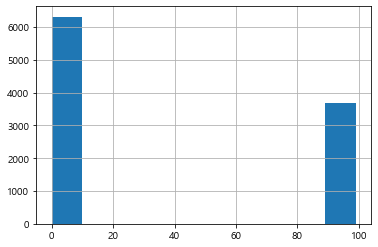

In [21]:
cus['ivs_icn_cd'].hist()

### 비상장 하드코딩 

In [22]:
besan =['286340', '281630', '27863K', '246780', '250990', '277290', '266930', '113300', '34534K', 
'214240', '270730', '304720', '064400', '339610', '319700', '318140', '294080', '258340', 
'228980', '156000', '312800', '228990', '34385K', '283970', '298410', '239280', '210160', 
'32904L', '272810', '309110', '357100', '276980', '280470', '289190', '292070', '298130', 
'300500', '302110', '306920', '093810', '163290', '179090', '194530', '199890', '226590', 
'240600', '244310', '255780', '271530', '271830', '298210', '311120', '255890', '34695K', 
'078510', '285340', '319810', '325840', '31508K', '31134K', '254650', '24251Q', '067030', 
'285820', '278470', '239620', '276040', '332760', '259070', '333900', '277490', '191390', 
'235370', '134660', '158320', '262100', '30703K', '29923L', '145730', '123780', '364460', 
'201400', '141280', '293990', '064470', '337280', '322590', '106870', '241660', '313100', 
'318590', '239970', '370310', '153760', '169830', '270530', '122230', '259290', '203900',
 '309740', '279120', '238820', '256970', '277310', '29922L', '30018L', '33129K', '333450',
 '366510', '350990', '306130', '226250', '258840', '004050', '32316K', '316840', '35732K', 
'145940', '276960', '249680', '240180', '236490', '299760', '314080', '316320', '336730',
 '340750', '170190', '177850', '234820', '244290', '258890', '259210', '266530', '142220',
 '35286N', '285880', '213930', '234760', '344250', '344540', '060080', '350340', '284710', 
'169140', '358580', '186630', '272850']

abesan = []
for i in besan:
    abesan.append('A' + i)

In [23]:
cus[cus['sex_dit_cd']==1]['act_id'].count() / cus['sex_dit_cd'].count()  #남자 59 여자 41

0.667

In [24]:
idx = test[test['iem_cd'].str[1:].isin(besan)]['submit_id']

### train에 hist_d 컬럼 만들기

In [25]:
train["hist_d"] = train["hold_d"]*0.6
train.hist_d = np.trunc(train["hist_d"])

### 파생변수(잔고/수량)

In [26]:
hist["stk_p"] = hist["tot_aet_amt"] / hist["bnc_qty"]
hist = hist.fillna(0)

# Data Merge

## merge

- train_data = train + cus + iem

In [27]:
train_data = pd.merge(train, cus, how = "left", on = ["act_id"])
train_data = pd.merge(train_data, iem, how = "left", on = ["iem_cd"])

test_data = pd.merge(test, cus, how = "left", on = ["act_id"])
test_data = pd.merge(test_data, iem, how = "left", on = ["iem_cd"])

- train_data + hist(매수일 = 기준일 처리)
- test_data + hist(매수일 = 기준일 처리)

In [28]:
# train_data
train_data = pd.merge(train_data, hist, how = "left", on = ["act_id", "iem_cd"])
train_data = train_data[(train_data["byn_dt"] == train_data["bse_dt"])]
train_data.reset_index(drop = True, inplace = True)

# test_data 
test_data = pd.merge(test_data, hist, how = "left", on = ["act_id", "iem_cd"])
test_data = test_data[(test_data["byn_dt"] == test_data["bse_dt"])]
test_data.reset_index(drop = True, inplace = True)

### Drop
- 투자성향('ivs_icn_cd')
- 주거래상품군('mrz_pdt_tp_sgm_cd')

In [29]:
train_data.drop(['mrz_pdt_tp_sgm_cd','ivs_icn_cd'], axis=1, inplace=True)
test_data.drop(['mrz_pdt_tp_sgm_cd','ivs_icn_cd'], axis=1, inplace=True)

- # Drop: 계좌ID, 종목코드, 매수일, 기준일 

In [30]:
train_data = train_data.drop(["act_id", "iem_krl_nm", "byn_dt", "bse_dt", 'stk_par_pr'], axis = 1)
test_data = test_data.drop(["act_id", "iem_krl_nm", "byn_dt", "bse_dt", 'stk_par_pr', "submit_id"], axis = 1)

### 인코딩: 한글이름

In [31]:
L_encoder = LabelEncoder()
L_encoder.fit(iem["iem_cd"])
train_data["iem_cd"] = L_encoder.transform(train_data["iem_cd"])
test_data["iem_cd"] = L_encoder.transform(test_data["iem_cd"])

### 상관분석

<AxesSubplot:>

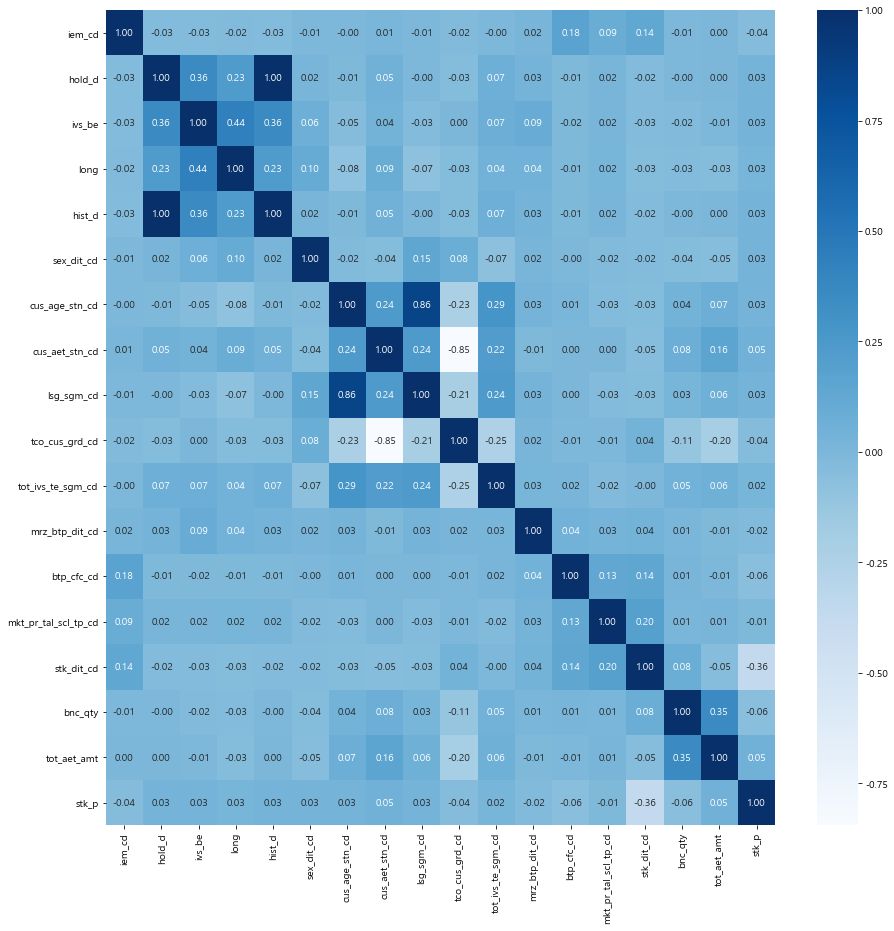

In [32]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train_data.corr(), fmt='.2f', annot=True, cmap='Blues')

# Feature Engineering 2

### PCA(LifeStage & 연령대)

In [33]:
train_data[['cus_age_stn_cd','lsg_sgm_cd']].head()

,cus_age_stn_cd,lsg_sgm_cd
0,9,9
1,9,9
2,9,9
3,9,9
4,9,9


In [34]:
pca = PCA(n_components=1)
pca.fit(train_data[['cus_age_stn_cd','lsg_sgm_cd']])
train_data['PCA_age_lsg'] = pca.transform(train_data[['cus_age_stn_cd','lsg_sgm_cd']])
pca.fit(test_data[['cus_age_stn_cd','lsg_sgm_cd']])
test_data['PCA_age_lsg'] = pca.transform(test_data[['cus_age_stn_cd','lsg_sgm_cd']])

print(pca.explained_variance_ratio_)

[0.93193502]


In [35]:
train_data['PCA_age_lsg']

0         5.563337
1         5.563337
2         5.563337
3         5.563337
4         5.563337
            ...   
681467   -2.178993
681468   -2.178993
681469   -2.178993
681470   -2.178993
681471   -2.178993
Name: PCA_age_lsg, Length: 681472, dtype: float64

In [36]:
train_data.drop(['cus_age_stn_cd','lsg_sgm_cd'], axis=1, inplace=True)
test_data.drop(['cus_age_stn_cd','lsg_sgm_cd'], axis=1, inplace=True)

### PCA(자산구간 & 서비스등급)

In [37]:
train_data[['cus_aet_stn_cd','tco_cus_grd_cd']].head()

,cus_aet_stn_cd,tco_cus_grd_cd
0,2,5
1,2,5
2,2,5
3,2,5
4,2,5


In [38]:
pca = PCA(n_components=1)
pca.fit(train_data[['cus_aet_stn_cd','tco_cus_grd_cd']])
train_data['PCA_cus'] = pca.transform(train_data[['cus_aet_stn_cd','tco_cus_grd_cd']])
pca.fit(test_data[['cus_aet_stn_cd','tco_cus_grd_cd']])
test_data['PCA_cus'] = pca.transform(test_data[['cus_aet_stn_cd','tco_cus_grd_cd']])

print(pca.explained_variance_ratio_)

[0.94850782]


In [39]:
train_data['PCA_cus']

0        -1.085031
1        -1.085031
2        -1.085031
3        -1.085031
4        -1.085031
            ...   
681467   -0.488011
681468   -0.488011
681469   -0.488011
681470   -0.488011
681471   -0.488011
Name: PCA_cus, Length: 681472, dtype: float64

In [40]:
train_data.drop(['cus_aet_stn_cd','tco_cus_grd_cd'], axis=1, inplace=True)
test_data.drop(['cus_aet_stn_cd','tco_cus_grd_cd'], axis=1, inplace=True)

### 스케일링(RobustScaler)

In [41]:
scaler_cols = train_data.drop('hold_d', axis=1).columns
scaler_cols

Index(['iem_cd', 'ivs_be', 'long', 'hist_d', 'sex_dit_cd', 'tot_ivs_te_sgm_cd',
       'mrz_btp_dit_cd', 'btp_cfc_cd', 'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd',
       'bnc_qty', 'tot_aet_amt', 'stk_p', 'PCA_age_lsg', 'PCA_cus'],
      dtype='object')

In [42]:
scaler = RobustScaler()

for col in scaler_cols:
    scaler.fit(np.array(train_data[col]).reshape(-1,1))
    train_data[col] = scaler.transform(np.array(train_data[col]).reshape(-1,1))
    test_data[col] = scaler.transform(np.array(test_data[col]).reshape(-1,1))

scaler_train = train_data
scaler_test = test_data

In [43]:
scaler_test.head()

,iem_cd,hist_d,hold_d,ivs_be,long,sex_dit_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_p,PCA_age_lsg,PCA_cus
0,-0.271215,18.875,0,1.640531,1.0,0.0,2.0,-0.666667,-1.0,-0.5,-1.010309,1.024896,1.182715,0.033710,1.283847,-0.329276
1,0.693012,41.625,0,1.640531,1.0,0.0,2.0,-0.666667,0.0,0.5,0.000000,0.601660,0.633411,0.021984,1.283847,-0.329276
2,0.960067,17.125,0,1.640531,1.0,0.0,2.0,-0.666667,0.5,0.0,0.000000,0.352697,1.316821,0.559871,1.283847,-0.329276
3,0.594010,29.250,0,1.640531,1.0,0.0,2.0,-0.666667,0.5,0.5,0.000000,12.112033,2.254532,-0.285505,1.283847,-0.329276
4,1.262063,0.875,0,1.640531,1.0,0.0,2.0,-0.666667,0.5,-0.5,-1.000000,-0.178423,-0.163186,1.009820,1.283847,-0.329276


In [44]:
scaler_train.head()

,iem_cd,hold_d,ivs_be,long,hist_d,sex_dit_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_p,PCA_age_lsg,PCA_cus
0,-0.645591,11,1.640531,1.0,0.500,0.0,2.0,-0.666667,-1.500000,-0.5,-1.010309,0.917012,4.213264,0.908691,1.189954,-0.271191
1,-0.664725,80,1.640531,1.0,5.750,0.0,2.0,-0.666667,-0.166667,-0.5,-1.010309,-0.211618,1.586814,72.783233,1.189954,-0.271191
2,-0.699667,5,1.640531,1.0,0.125,0.0,2.0,-0.666667,0.333333,0.0,0.000000,3.041494,5.310557,0.193463,1.189954,-0.271191
3,-0.769551,22,1.640531,1.0,1.375,0.0,2.0,-0.666667,-0.333333,0.0,-1.010309,0.029046,-0.164153,-0.126044,1.189954,-0.271191
4,-0.826123,324,1.640531,1.0,24.000,0.0,2.0,-0.666667,0.000000,0.5,0.000000,0.539419,2.799188,0.949729,1.189954,-0.271191


### log 스케일(hold_d)

In [45]:
scaler_train['hold_d'] = np.log1p(scaler_train['hold_d'])

In [46]:
scaler_train.head()

,iem_cd,hold_d,ivs_be,long,hist_d,sex_dit_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_p,PCA_age_lsg,PCA_cus
0,-0.645591,2.484907,1.640531,1.0,0.500,0.0,2.0,-0.666667,-1.500000,-0.5,-1.010309,0.917012,4.213264,0.908691,1.189954,-0.271191
1,-0.664725,4.394449,1.640531,1.0,5.750,0.0,2.0,-0.666667,-0.166667,-0.5,-1.010309,-0.211618,1.586814,72.783233,1.189954,-0.271191
2,-0.699667,1.791759,1.640531,1.0,0.125,0.0,2.0,-0.666667,0.333333,0.0,0.000000,3.041494,5.310557,0.193463,1.189954,-0.271191
3,-0.769551,3.135494,1.640531,1.0,1.375,0.0,2.0,-0.666667,-0.333333,0.0,-1.010309,0.029046,-0.164153,-0.126044,1.189954,-0.271191
4,-0.826123,5.783825,1.640531,1.0,24.000,0.0,2.0,-0.666667,0.000000,0.5,0.000000,0.539419,2.799188,0.949729,1.189954,-0.271191


In [47]:
scaler_train.shape, scaler_test.shape, sub.shape

((681472, 16), (70596, 16), (70596, 2))

In [48]:
scaler_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681472 entries, 0 to 681471
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   iem_cd                681472 non-null  float64
 1   hold_d                681472 non-null  float64
 2   ivs_be                681472 non-null  float64
 3   long                  681472 non-null  float64
 4   hist_d                681472 non-null  float64
 5   sex_dit_cd            681472 non-null  float64
 6   tot_ivs_te_sgm_cd     681472 non-null  float64
 7   mrz_btp_dit_cd        681472 non-null  float64
 8   btp_cfc_cd            681472 non-null  float64
 9   mkt_pr_tal_scl_tp_cd  681472 non-null  float64
 10  stk_dit_cd            681472 non-null  float64
 11  bnc_qty               681472 non-null  float64
 12  tot_aet_amt           681472 non-null  float64
 13  stk_p                 681472 non-null  float64
 14  PCA_age_lsg           681472 non-null  float64
 15  

### hold_d drop

In [49]:
train_label = scaler_train["hold_d"]
scaler_train.drop(["hold_d"], axis = 1, inplace = True)

# Modeling(CatBoostRegressor)

In [50]:
models = []

folds = KFold(n_splits=10)
for train_idx, val_idx in folds.split(scaler_train):
    
    train_x = train_data.iloc[train_idx, :]
    train_y = train_label[train_idx]
    val_x = train_data.iloc[val_idx, :]
    val_y = train_label[val_idx]
    
    model =CatBoostRegressor(learning_rate=0.03,
                        depth=2,
                        use_best_model=True,
                        random_seed=14,
                        loss_function='RMSE')
    
  
    model.fit(train_x, train_y,
              eval_set=[(val_x, val_y)],
              verbose=500)
    
    models.append(model)

0:	learn: 1.2274197	test: 1.3033558	best: 1.3033558 (0)	total: 307ms	remaining: 5m 6s
500:	learn: 0.0687869	test: 0.0681332	best: 0.0681332 (500)	total: 46.7s	remaining: 46.5s
999:	learn: 0.0686937	test: 0.0680176	best: 0.0680176 (999)	total: 1m 32s	remaining: 0us

bestTest = 0.06801756662
bestIteration = 999

0:	learn: 1.2235250	test: 1.3364811	best: 1.3364811 (0)	total: 163ms	remaining: 2m 43s
500:	learn: 0.0688251	test: 0.0678097	best: 0.0678097 (500)	total: 46.7s	remaining: 46.5s
999:	learn: 0.0687246	test: 0.0677263	best: 0.0677263 (999)	total: 1m 33s	remaining: 0us

bestTest = 0.06772634316
bestIteration = 999

0:	learn: 1.2215911	test: 1.3526781	best: 1.3526781 (0)	total: 120ms	remaining: 1m 59s
500:	learn: 0.0689415	test: 0.0669693	best: 0.0669693 (500)	total: 56.3s	remaining: 56.1s
999:	learn: 0.0688140	test: 0.0668471	best: 0.0668471 (999)	total: 1m 46s	remaining: 0us

bestTest = 0.06684709432
bestIteration = 999

0:	learn: 1.2285081	test: 1.2942645	best: 1.2942645 (0)	total:

# 결과추론

In [51]:
result = []
for i in models:
    result.append(i.predict(scaler_test.drop('hold_d', axis = 1)))
pred = np.mean(result, axis = 0)

In [52]:
pred

array([5.56409707, 6.3253989 , 5.45420257, ..., 6.66499588, 3.00043092,
       2.13449591])

In [53]:
pred = np.expm1(pred)
pred

array([259.88953158, 557.580585  , 232.73840667, ..., 783.46023253,
        19.09419412,   7.45278451])

In [54]:
len(pred)

70596

In [55]:
sub["hold_d"] = np.round(pred)

In [56]:
sub.head()

,submit_id,hold_d
0,IDX00001,260.0
1,IDX00002,558.0
2,IDX00003,233.0
3,IDX00004,394.0
4,IDX00005,16.0


### hold_d의 outlier 제거

In [57]:
test.head()

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d,ivs_be,long
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,0,15.569043,1
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A160600,20190823,335,IDX00002,0,15.569043,1
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A234340,20200611,139,IDX00003,0,15.569043,1
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A131760,20200120,236,IDX00004,0,15.569043,1
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A293490,20201217,9,IDX00005,0,15.569043,1


In [58]:
sub["outlier"]=sub["hold_d"]-test["hist_d"]
sub.head()

,submit_id,hold_d,outlier
0,IDX00001,260.0,107.0
1,IDX00002,558.0,223.0
2,IDX00003,233.0,94.0
3,IDX00004,394.0,158.0
4,IDX00005,16.0,7.0


In [59]:
sub.loc[sub['outlier']<0, 'outlier'] = 1  # under 0 -> 1

In [60]:
sub[sub["outlier"] == 1].value_counts().sum()

2693

In [61]:
sub.loc[sub['outlier']>146, 'outlier'] = 146 # above 146 -> 146

In [62]:
sub[sub["outlier"] == 146].value_counts().sum()

7574

### 비상장 -> hold = 146

In [63]:
for i in idx: # idx : 비상장 인덱스
    sub.loc[sub['submit_id']==i, 'outlier'] = 146

In [64]:
sub[sub["outlier"] == 146].value_counts().sum()

7650

### hold_d = hist_d + outlier(20년 12월 이후 보유일)

In [65]:
sub['hold_d'] = sub['outlier'] + test['hist_d']  

In [66]:
sub.drop("outlier",axis=1,inplace=True)

In [67]:
sub.head()

,submit_id,hold_d
0,IDX00001,260.0
1,IDX00002,481.0
2,IDX00003,233.0
3,IDX00004,382.0
4,IDX00005,16.0


### 최종 출력

In [68]:
sub.to_csv("NH_hold.csv", index = False)